
# TF-recomm


In [1]:
import time
from collections import deque
import socket
import sys
import numpy as np
import tensorflow as tf
from six import next
from tensorflow.core.framework import summary_pb2
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

import dataio
import ops
# tensorboard --logdir=.\_zfp\data\my_graph
# tensorboard => http://localhost:6006 
# jupyter => http://localhost:8889

In [25]:
import random
import matplotlib.pyplot as plt
# from wordcloud import WordCloud, STOPWORDS #used to generate world cloud



In [2]:
np.random.seed(13575)

BATCH_SIZE = 1000
USER_NUM = 6040
ITEM_NUM = 3952
DIM = 15
EPOCH_MAX = 100
DEVICE = "/cpu:0"

In [3]:
def clip(x):
    return np.clip(x, 1.0, 5.0)


def make_scalar_summary(name, val):
    return summary_pb2.Summary(value=[summary_pb2.Summary.Value(tag=name, simple_value=val)])

def get_data():
    df = dataio.read_process("./tmp/movielens/ml-1m/ratings.dat", sep="::")
    rows = len(df)
    df = df.iloc[np.random.permutation(rows)].reset_index(drop=True)
    split_index = int(rows * 0.9)
    df_train = df[0:split_index]
    df_test = df[split_index:].reset_index(drop=True)
    return df_train, df_test, rows

def get_movies():
    df = dataio.read_movies("./tmp/movielens/ml-1m/movies.dat", sep="::")
    rows = len(df)
    return df, rows

# Data

In [34]:
df_train, df_test, length = get_data()
df_movies,rows = get_movies()

Movies file length:
3883
Toy Story (1995)
1
Animation|Children's|Comedy


In [50]:
print("ratings: {} - tr{} - ts{}" .format(length, len(df_train),len(df_test) ))
df_ratings = pd.concat([df_train, df_test ] )
len(df_ratings)

ratings: 1000209 - tr900188 - ts100021


1000209

In [5]:
print(df_train.iloc[0:10])
df_train.describe()

   user  item  rate         st
0  1893  1692   4.0  974695176
1  5947  2312   4.0  957190990
2   162   365   2.0  977323187
3  5117   456   3.0  962294766
4  2029   315   1.0  974929369
5  2220  1844   5.0  974603135
6  4385  3385   3.0  965172804
7  5779   282   4.0  958156569
8  3617  3740   2.0  966600773
9  3640   584   4.0  966482594


,user,item,rate,st
count,900188.000000,900188.000000,900188.000000,9.001880e+05
mean,3022.600601,1864.635758,3.581352,9.722461e+08
std,1728.384446,1096.003424,1.117216,1.215377e+07
min,0.000000,0.000000,1.000000,9.567039e+08
25%,1504.000000,1029.000000,3.000000,9.653027e+08
50%,3068.000000,1834.000000,4.000000,9.730215e+08
75%,4475.000000,2769.000000,4.000000,9.752212e+08
max,6039.000000,3951.000000,5.000000,1.046455e+09


In [6]:
print ("Movies file length: {}" .format(len(df_movies)))

Movies file length: 3883


In [7]:
df_movies.iloc[0:10]

,movie,title,tags
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [8]:
df_movies.iloc[0].title

'Toy Story (1995)'

In [21]:
# type(df_movies)

In [28]:
# get titles
# df_movies.head() # display first 5entries
df_movies.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie    3883 non-null int32
title    3883 non-null object
tags     3883 non-null object
dtypes: int32(1), object(2)
memory usage: 75.9+ KB


In [33]:
#number of unique movies
movies = df_movies['movie'].unique().tolist()
print("unique number of movies: " + str(len(movies)) )

unique number of movies: 3883


In [51]:
df_ratings.describe() #min 1 - max 5

,user,item,rate,st
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.023512e+03,1.864540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,0.000000e+00,0.000000e+00,1.000000e+00,9.567039e+08
25%,1.505000e+03,1.029000e+03,3.000000e+00,9.653026e+08
50%,3.069000e+03,1.834000e+03,4.000000e+00,9.730180e+08
75%,4.475000e+03,2.769000e+03,4.000000e+00,9.752209e+08
max,6.039000e+03,3.951000e+03,5.000000e+00,1.046455e+09


In [65]:
df_ratings.head()

,user,item,rate,st
0,2662,3209,4.0,973459383
1,1752,1911,5.0,974702638
2,2105,2452,1.0,974755210
3,1779,3051,2.0,1027037687
4,1697,1526,3.0,974773234


In [57]:
# data clean up: 
df_movies.shape # 3883, 3
df_movies.isnull().any() #is any row null: False 
df_ratings.shape #1000209 4
df_ratings.isnull().any() # False! 
# ? tags... ml2-m ... 
# tags_data=pd.read_csv('../input/tags.csv',sep=',')
# tags_data.shape
# tags_data.isnull().any()
# tags_data.dopna()
# unique_tags=tags_data['tag'].unique().tolist()
# len(unique_tags)
print("data clean up")

data clean up


In [63]:
comedy_movies = df_movies['tags'].str.contains('Comedy')
df_movies[comedy_movies].head()

,movie,title,tags
0,1,Toy Story (1995),Animation|Children's|Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
6,7,Sabrina (1995),Comedy|Romance


In [71]:
movie_data_ratings_data=df_movies.merge(df_ratings, left_on = "movie" , right_on = 'item', how = 'inner') #on= "movieId"
movie_data_ratings_data.head(3)

,movie,title,tags,user,item,rate,st
0,1,Toy Story (1995),Animation|Children's|Comedy,367,1,4.0,976671174
1,1,Toy Story (1995),Animation|Children's|Comedy,146,1,4.0,977357720
2,1,Toy Story (1995),Animation|Children's|Comedy,5633,1,4.0,959008544


In [74]:
high_rated= movie_data_ratings_data['rate']>4.0
movie_data_ratings_data[high_rated].head(10)


,movie,title,tags,user,item,rate,st
12,1,Toy Story (1995),Animation|Children's|Comedy,3307,1,5.0,967975269
22,1,Toy Story (1995),Animation|Children's|Comedy,1995,1,5.0,974681923
76,1,Toy Story (1995),Animation|Children's|Comedy,3710,1,5.0,966270677
105,1,Toy Story (1995),Animation|Children's|Comedy,691,1,5.0,975739161
117,1,Toy Story (1995),Animation|Children's|Comedy,5567,1,5.0,959310761
129,1,Toy Story (1995),Animation|Children's|Comedy,59,1,5.0,977931869
136,1,Toy Story (1995),Animation|Children's|Comedy,5924,1,5.0,957294433
160,1,Toy Story (1995),Animation|Children's|Comedy,1982,1,5.0,975054170
165,1,Toy Story (1995),Animation|Children's|Comedy,4818,1,5.0,962923274
168,1,Toy Story (1995),Animation|Children's|Comedy,4206,1,5.0,965326554


In [75]:
most_rated = movie_data_ratings_data.groupby('title').size().sort_values(ascending=False)[:25]
most_rated.head(25)

title
Yellow Submarine (1968)                                  3428
Kiss of Death (1995)                                     2991
Once Upon a Time in the West (1969)                      2883
Judgment Night (1993)                                    2672
Mafia! (1998)                                            2653
Aladdin (1992)                                           2649
Walk on the Moon, A (1999)                               2590
Arsenic and Old Lace (1944)                              2583
Batman (1989)                                            2578
For Ever Mozart (1996)                                   2538
Princess Bride, The (1987)                               2514
Century (1993)                                           2513
Iron Giant, The (1999)                                   2459
Headless Body in Topless Bar (1995)                      2443
Rushmore (1998)                                          2369
Star Wars: Episode V - The Empire Strikes Back (1980)    2318
Sa

In [77]:
# df_movies[['title','genres']].head()
# get the year of the movies: 
df_movies['year'] =df_movies['title'].str.extract('.*\((.*)\).*',expand = False)
df_movies.head(5)



,movie,title,tags,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [78]:
# count how many times each genre appear: 
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [80]:
genre_labels = set()
for s in df_movies['tags'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [82]:
keyword_occurences, dum = count_word(df_movies, 'tags', genre_labels)
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Western', 68],
 ['Fantasy', 68],
 ['Film-Noir', 44]]

In [84]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
# wordcloud = WordCloud(width=550,height=300, background_color='black', 
#                       max_words=1628,relative_scaling=0.7,
#                       color_func = random_color_func,
#                       normalize_plurals=False)
# wordcloud.generate_from_frequencies(words)
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

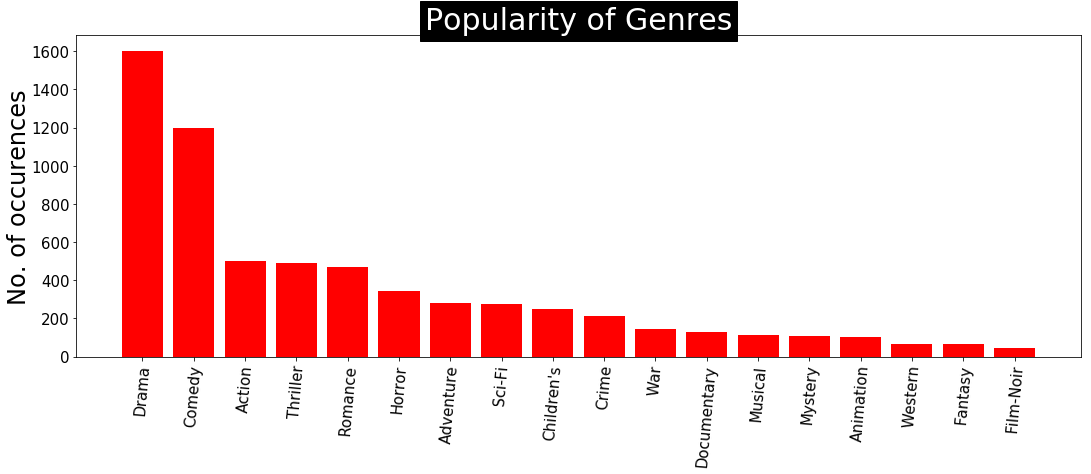

In [86]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [12]:
def printMM(topmovies):
    print (topmovies)
    print("TOP Movies")
    for i,r in topmovies:
        print("{0:5} - {1:1.2f} - {2}" .format(i,  r, df_movies.iloc[i].title  ))

In [15]:
import pandas as pd

In [16]:
def get_users():
    col_names = ["userID", "gender", "age", "occupation", "zipcode"]
    df = pd.read_csv("./tmp/movielens/ml-1m/users.dat", sep="::", header=None, names=col_names, engine='python')
    rows = len(df)
    return df, rows


In [17]:
df_users,rows = get_users()


In [18]:
print(len(df_users))
df_users.describe()

6040


,userID,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [19]:
df_users.iloc[0:10]

,userID,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


## FIND similar users 


In [20]:
def get_users_where(age="*", gender="*", occupation="*", zipcode="*"): 
    us = df_users
    if age != "*":
        us = us[us["age"]==age]
    if gender != "*":
        us = us[us["gender"]==gender]
    if occupation != "*":
        us = us[us["occupation"]==occupation]
    if zipcode != "*":
        us = us[us["zipcode"]==zipcode]    
    return us # return the data 
#     return len(us) return the length of each selection

# print(get_users_where(age=1) )
# print(get_users_where(age=1, gender ="M") )
print(get_users_where(age=1, gender ="M", occupation = 1 ) )
# print(get_users_where(age=1, gender ="M", occupation = 1, zipcode = 48067 ) )


      userID gender  age  occupation zipcode
1814    1815      M    1           1   30707
2059    2060      M    1           1   48304
2852    2853      M    1           1  444555


# Compare results - Show statistics

In [22]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    #saver.restore(sess, "./tmp/")
    movies=list(range(len(df_movies)))

    user_IDEN = get_users_where(age=1, gender ="M", occupation = 1 )
    print ("\nTop Movies ------------------------------------------------------------")

    for i in range(len(user_IDEN)):
        userID = user_IDEN.iloc[i]["userID"]
        print(userID)
        users=[userID]
        pred_batch = sess.run(infer, feed_dict={user_batch: users,item_batch: movies})
        moviesrecomm=list(zip(movies,pred_batch))
        smovies=sorted (moviesrecomm,key=lambda x:x[1],reverse=True)
        topmovies= smovies[0:10]
        printMM(topmovies)


Top Movies ------------------------------------------------------------
1815
[(3154, -1.2711122), (542, -1.2713907), (1784, -1.2718444), (2258, -1.2719319), (1000, -1.2721136), (3471, -1.2722907), (2529, -1.2724241), (3009, -1.2725339), (1840, -1.2727556), (1460, -1.2728013)]
TOP Movies
 3154 - -1.27 - Zed & Two Noughts, A (1985)
  542 - -1.27 - Super Mario Bros. (1993)
 1784 - -1.27 - Alan Smithee Film: Burn Hollywood Burn, An (1997)
 2258 - -1.27 - Tales from the Darkside: The Movie (1990)
 1000 - -1.27 - Parent Trap, The (1961)
 3471 - -1.27 - Passion of Mind (1999)
 2529 - -1.27 - Pushing Tin (1999)
 3009 - -1.27 - Liberty Heights (1999)
 1840 - -1.27 - X-Files: Fight the Future, The (1998)
 1460 - -1.27 - B*A*P*S (1997)
2060
[(3070, -1.3068042), (3471, -1.3079368), (1512, -1.3079507), (3552, -1.3081417), (2711, -1.3082843), (408, -1.3083031), (734, -1.308417), (542, -1.3084476), (847, -1.3085543), (472, -1.3087789)]
TOP Movies
 3070 - -1.31 - Tarzan the Fearless (1933)
 3471 - -1

# movies watched by users... 

In [34]:
def getAg(age):
    if age == 1:    return "Under 18"
    elif age == 18: return "18 - 24 "
    elif age == 25: return "25 - 34 "
    elif age == 35: return "35 - 44 "
    elif age == 45: return "45 - 49 "
    elif age == 50: return "50 - 55 "
    elif age == 56: return "Above 56"

def getOc(occ):
    if occ == 0:    return "other"
    elif occ == 1:  return "academic/educator"
    elif occ == 2:  return "artist"
    elif occ == 3:  return "clerical/admin"
    elif occ == 4:  return "college/grad student"
    elif occ == 5:  return "customer service"
    elif occ == 6:  return "doctor/health care"
    elif occ == 7:  return "executive/managerial"
    elif occ == 8:  return "farmer"
    elif occ == 9:  return "homemaker"
    elif occ == 10: return "K-12 student"
    elif occ == 11: return "lawyer"
    elif occ == 12: "programmer"
    elif occ == 13: "retired"
    elif occ == 14: "sales/marketing"
    elif occ == 15: "scientist"
    elif occ == 16: "self-employed"
    elif occ == 17: "technician/engineer"
    elif occ == 18: "tradesman/craftsman"
    elif occ == 19: "unemployed"
    elif occ == 20: "writer"
        
userID = 1.
user = df_users[df_users["userID"]==userID]

print("id: {}, G: {}, age {}, oc: {}, zc: {}" 
      .format(user["userID"][0], user["gender"][0], getAg(user["age"][0]), user["occupation"][0], user["zipcode"][0] ))
# for i,r in topmovies:
#     print("{0:5} - {1:1.2f} - {2}" .format(i,  r, df_movies.iloc[i].title  ))


id: 1, G: F, age Under 18, oc: 10, zc: 48067


1